# Missing Tree Analysis - Aerobotics Challenge, Cape Town, South Africa

# Submission Update (Notebook 2)
# Concave Hull Methodology

Inspiring Read can be found here about the concave hull work https://towardsdatascience.com/the-concave-hull-c649795c0f0f

This notebook is using data from the developers API at Aerobotics. The goal is to investigate the data and find what the locations are of specific missing trees!

After an initial attempt I needed to refine the work so that it could be applied to any orchard - assuming the same variables and structure

## This specific notebook focuses on using the Concave Hull as our orchard perimeter

In [16]:
import os
import psycopg2
import psycopg2.extras as extras
from io import StringIO
from datetime import datetime, timedelta
import requests
import json
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.neighbors import BallTree, KDTree
from scipy.spatial import ConvexHull
from ipynb.fs.full.geomath_hulls import ConcaveHull
from ipynb.fs.full.functions import ball_tree_avg_distance, project_points, create_polygon, point_in_convex_hull, initial_blue_frame, create_red_frame, calculate_initial_compass_bearing
from shapely import geometry
import matplotlib.path as mpltPath
%matplotlib inline

# Fetch the data
my_headers = {'Authorization' : '1566394169B0EJX2MGAVKVUGGKEMKZBMND9A7VCR'}

treesurveys = requests.get('https://sherlock.aerobotics.com/developers/treesurveys/', headers=my_headers)
surveys = requests.get('https://sherlock.aerobotics.com/developers/surveys/', headers=my_headers)

treesurvey_response = treesurveys.json()
survey_response = surveys.json()

treesurvey_df = pd.DataFrame(treesurvey_response['results'])
survey_df = pd.DataFrame(survey_response['results'])

search_orchard_id = 216269
# Select the survey where the orchard_id = search_orchard_id
search_survey_id = survey_df.loc[survey_df['orchard_id'] == search_orchard_id]['id'][0]
search_survey_id

# Select the tree surveys where the survey_id = search_survey_id
treesurvey_df = treesurvey_df.loc[treesurvey_df['survey_id'] == search_survey_id]
# Drop the area, height, id, ndre, ndvi, radius, volume   columns
treesurvey_df.drop(['area', 'height', 'id', 'ndre', 'ndvi', 'radius', 'volume'], axis='columns', inplace=True)
# Add orchard_id column to the frame
treesurvey_df['orchard_id'] = search_orchard_id
treesurvey_df.head()

,latitude,longitude,survey_id,tree_id,orchard_id
0,-32.327591,18.826167,25319,38869352,216269
1,-32.327561,18.826040,25319,38869351,216269
2,-32.327546,18.825974,25319,38869350,216269
3,-32.327571,18.826103,25319,38869349,216269
4,-32.327561,18.825765,25319,38869348,216269


## Work out the Concave Hull for this Orchard (our perimeter for points)

In [17]:
# Constructing the input point data
points = np.column_stack((treesurvey_df.latitude,treesurvey_df.longitude))

# Create the concave hull object
concave_hull = ConcaveHull(points)

# Calculate the concave hull array
concave_hull_array = concave_hull.calculate()

orco = []
for x in concave_hull_array:
    latstr = str(x[1])
    lonstr = str(x[0])
    res = eval("(" + latstr + ", "+ lonstr +")")
    orco.append(res)

orchfile = create_polygon(orco, 'Orchard Concave Polygon')

ipynb.fs.full.functions:113: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
/Users/moonwrench/opt/anaconda3/envs/python-cvcourse/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


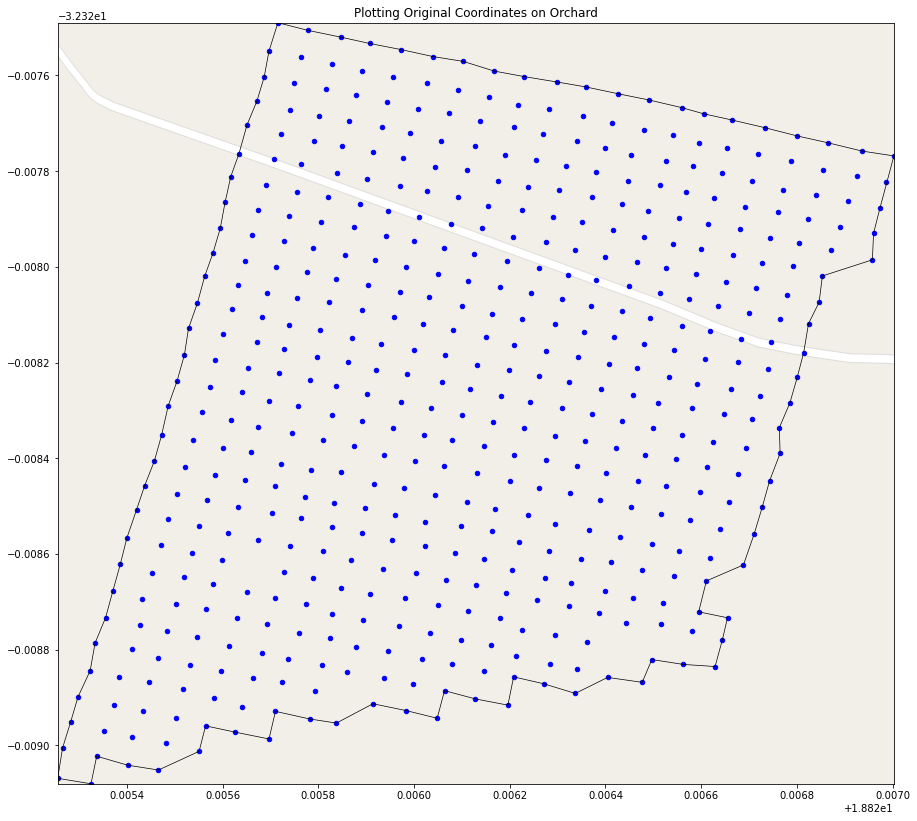

In [18]:
bbox = ((treesurvey_df.longitude.min(), treesurvey_df.longitude.max(), treesurvey_df.latitude.min(), treesurvey_df.latitude.max()))
farm_map = plt.imread('map.png')

fig, ax = plt.subplots(figsize = (15,14))

ax.scatter(treesurvey_df.longitude, treesurvey_df.latitude, zorder=1, alpha = 1, c='b', s=20)
orchfile['geometry'].plot(ax=ax, facecolor="none", edgecolor='black', lw=0.7)
# ax.plot()

ax.set_title('Plotting Original Coordinates on Orchard')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2], bbox[3])

ax.imshow(farm_map, zorder=0, extent = bbox, aspect = 'equal')

# Work out the avg distance metric for this orchard in metres
## This uses the same Ball Tree methodology used before

In [19]:
orch_avg_dist, balltree_df = ball_tree_avg_distance(treesurvey_df, treesurvey_df, 5)
orch_avg_dist

0.006401409141045342

# Work out the bearing for orchard

In [20]:
# Calculate Bearing of Orchard
minlonrow = treesurvey_df.loc[treesurvey_df['longitude'] == treesurvey_df.longitude.min()]
maxlatrow = treesurvey_df.loc[treesurvey_df['latitude'] == treesurvey_df.latitude.max()]

minlong_lat = minlonrow.iloc[0]['latitude']
minlong_lon = minlonrow.iloc[0]['longitude']

maxlat_lat = maxlatrow.iloc[0]['latitude']
maxlat_lon = maxlatrow.iloc[0]['longitude']

bearing = calculate_initial_compass_bearing((minlong_lat,minlong_lon),(maxlat_lat,maxlat_lon))
# covert degrees to radians
b_rad = np.deg2rad(bearing)

# New points to Test
## Im going to project 2 new points for each tree (essentially forward and backward with bearing)
## These points will then be tested individually to find missing gaps in the orchard

In [21]:
treesurvey_df[["newlatup", "newlonup", "newlatdown", "newlondown"]] = treesurvey_df.apply(lambda x: project_points(x.latitude, x.longitude, orch_avg_dist, b_rad), axis=1, result_type="expand")
treesurvey_df.head()

,latitude,longitude,survey_id,tree_id,orchard_id,latitude_rad,longitude_rad,newlatup,newlonup,newlatdown,newlondown
0,-32.327591,18.826167,25319,38869352,216269,-0.564223,0.328579,-32.327535,18.826183,-32.327647,18.826151
1,-32.327561,18.826040,25319,38869351,216269,-0.564222,0.328576,-32.327505,18.826056,-32.327616,18.826024
2,-32.327546,18.825974,25319,38869350,216269,-0.564222,0.328575,-32.327490,18.825990,-32.327602,18.825957
3,-32.327571,18.826103,25319,38869349,216269,-0.564223,0.328577,-32.327515,18.826119,-32.327626,18.826086
4,-32.327561,18.825765,25319,38869348,216269,-0.564222,0.328572,-32.327505,18.825781,-32.327616,18.825748


In [22]:
# Lets process Latitude points first and then Longitudes
point_process_names = ['newlatup', 'newlatdown', 'newlonup', 'newlondown']

# Plot 1 - Forward

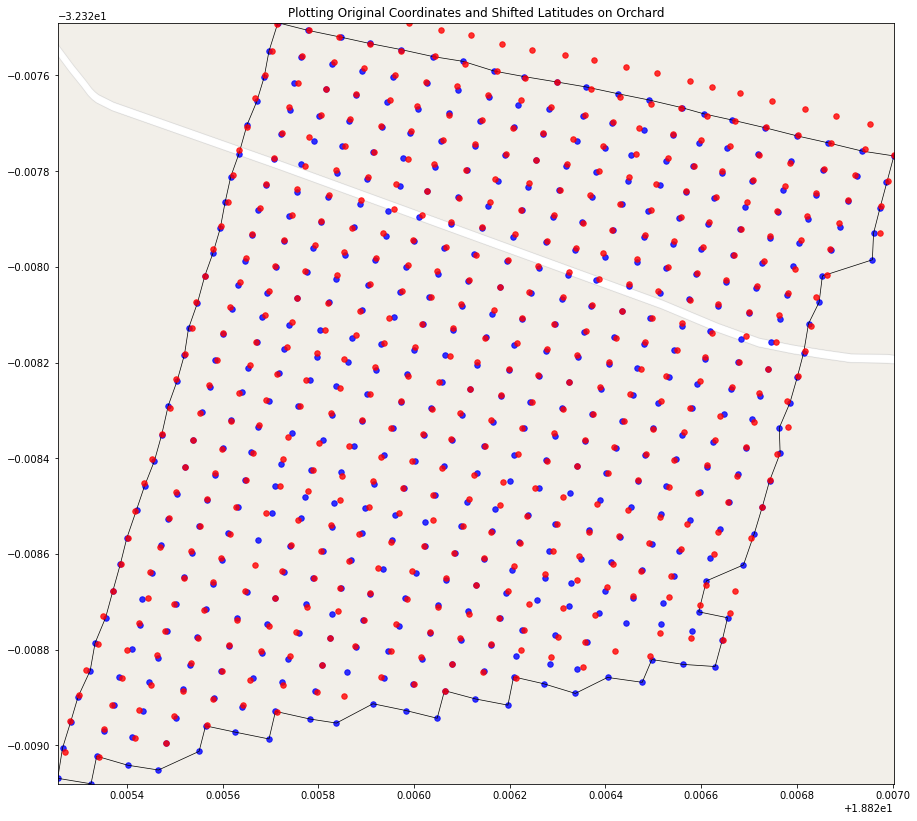

In [23]:
fig, ax = plt.subplots(figsize = (15,14))

# Original Points
ax.scatter(treesurvey_df.longitude, treesurvey_df.latitude, zorder=1, alpha = 0.8, c='b', s=30)
#Concave Hull Border Plot
orchfile['geometry'].plot(ax=ax, facecolor="none", edgecolor='black', lw=0.7)
# Latitude Up Points
ax.scatter(treesurvey_df.newlonup, treesurvey_df.newlatup, zorder=1, alpha = 0.8, c='r', s=30)

ax.set_title('Plotting Original Coordinates and Shifted Latitudes on Orchard')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2], bbox[3])

ax.imshow(farm_map, zorder=0, extent = bbox, aspect = 'equal')

## Point Strategy Reminder
- So the logic is: check if that new point has a neighbour close to it ( a blue neighbour)
- If the new point does have a blue neighbour close to it, reject the creation
- Close will be defined as the orch_avg_dist / 2
- "Of the new points projected, how close are they to the original points (avg distance)"

In [24]:
blue_df = initial_blue_frame(treesurvey_df)

ptype = 'up'

red_df = create_red_frame(treesurvey_df, ptype)

new_avg_dist, balltree_df = ball_tree_avg_distance(blue_df, red_df, 1)

pc = np.column_stack((balltree_df.latitude,balltree_df.longitude))

path = mpltPath.Path(concave_hull_array)
balltree_df['point_check'] = path.contains_points(pc)

treesurvey_new_points = balltree_df[balltree_df.point_check]

check = treesurvey_new_points[treesurvey_new_points['distance_1'] > (orch_avg_dist / 2)]

# Create the missing Dataframe
missing_df = check[['tree_id', 'latitude', 'longitude']].copy()
missing_df

,tree_id,latitude,longitude
59,38868729,-32.328802,18.826421
117,38869753,-32.328898,18.825854
208,38869622,-32.328624,18.825667


## We now have a frame containing missing points identified from the first point projection analysis
## Lets merge them to the blue_df frame (original points) so we can track them against the next point projection
## Then recreate the RED or test frame using the 2nd point (Backward or Down)

In [25]:
#########
blue_df = pd.concat([blue_df, missing_df], axis=0,sort=True)
#########

ptype = 'down'

red_df = create_red_frame(treesurvey_df, ptype)

new_avg_dist, balltree_df = ball_tree_avg_distance(blue_df, red_df, 1)

# Plot 2 - Down

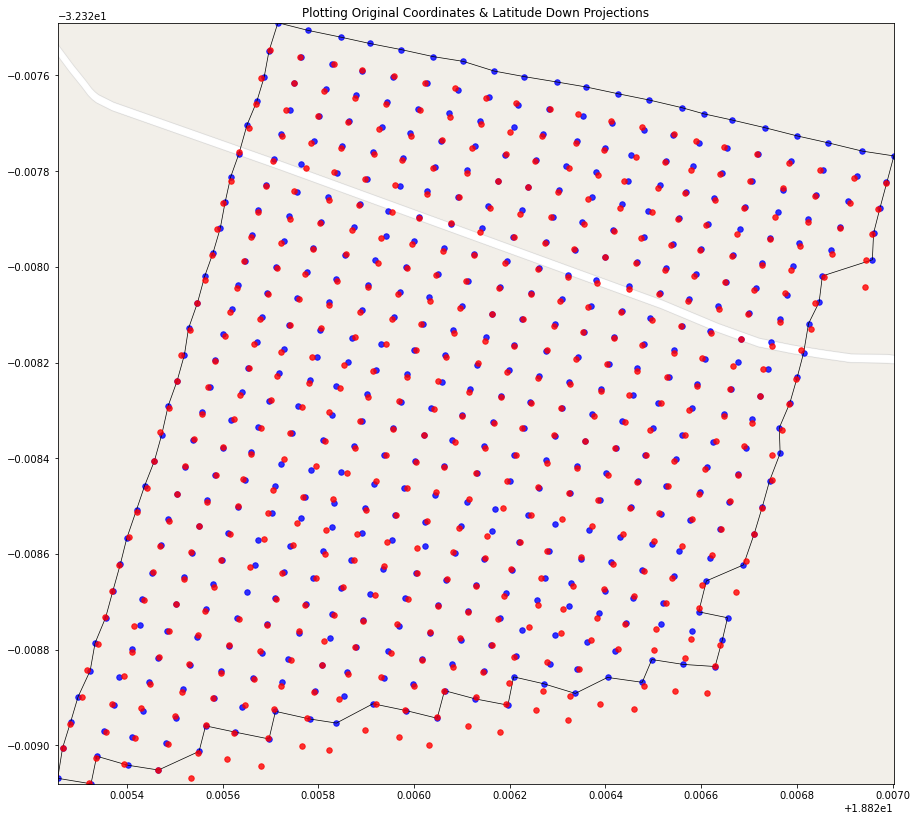

In [26]:
fig, ax = plt.subplots(figsize = (15,14))

# Original Points
ax.scatter(blue_df.longitude, blue_df.latitude, zorder=1, alpha = 0.8, c='b', s=30)
#Concave Hull Border Plot
orchfile['geometry'].plot(ax=ax, facecolor="none", edgecolor='black', lw=0.7)
# Down Points
ax.scatter(red_df.longitude, red_df.latitude, zorder=1, alpha = 0.8, c='r', s=30)

ax.set_title('Plotting Original Coordinates & Latitude Down Projections')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2], bbox[3])

ax.imshow(farm_map, zorder=0, extent = bbox, aspect = 'equal')

In [27]:
pc = np.column_stack((balltree_df.latitude,balltree_df.longitude))

path = mpltPath.Path(concave_hull_array)
balltree_df['point_check'] = path.contains_points(pc)

treesurvey_new_points = balltree_df[balltree_df.point_check]

check = treesurvey_new_points[treesurvey_new_points['distance_1'] > (orch_avg_dist / 2)]

########################
# Create the missing Dataframe
add_missing_df = check[['tree_id', 'latitude', 'longitude']].copy()
missing_df = pd.concat([missing_df, add_missing_df], axis=0,sort=True)
missing_df

,latitude,longitude,tree_id
59,-32.328802,18.826421,38868729
117,-32.328898,18.825854,38869753
208,-32.328624,18.825667,38869622


# Plot Missing Trees

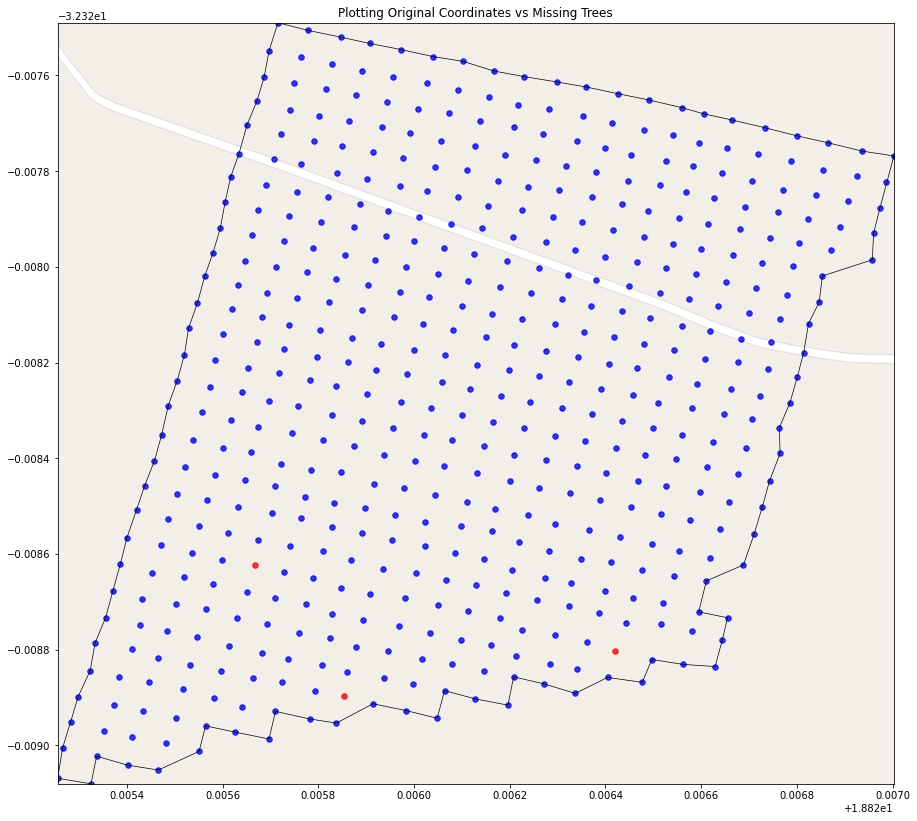

In [28]:
fig, ax = plt.subplots(figsize = (15,14))

# Original Points
ax.scatter(treesurvey_df.longitude, treesurvey_df.latitude, zorder=1, alpha = 0.8, c='b', s=30)
#Concave Hull Border Plot
orchfile['geometry'].plot(ax=ax, facecolor="none", edgecolor='black', lw=0.7)
# Latitude Down Points
ax.scatter(missing_df.longitude, missing_df.latitude, zorder=1, alpha = 0.8, c='r', s=30)

ax.set_title('Plotting Original Coordinates vs Missing Trees')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2], bbox[3])

ax.imshow(farm_map, zorder=0, extent = bbox, aspect = 'equal')